In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx
import random
from torch import tensor, Tensor
from scipy.stats.sampling import DiscreteAliasUrn
import numpy as np
from sklearn.preprocessing import normalize

In [14]:
EMBEDDING_SIZE = 2
WALK_LENGTH = 10
WALKS_PER_VERTEX = 10
WINDOW_SIZE = 3
INIT_LEARNING_RATE = 0.01
MIN_LR_RATE = 0.3
K = 3
p = 2.0 # return parameter
q = 1.0 # io parameter    

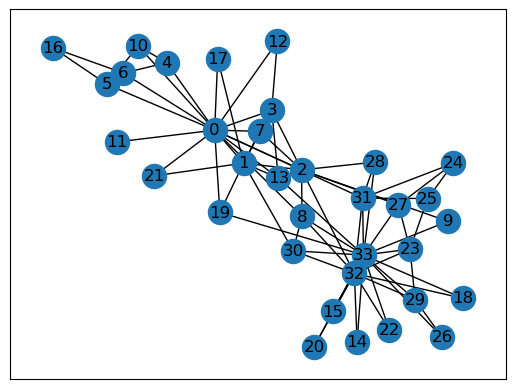

In [15]:
# Load dataset
g: nx.Graph = nx.karate_club_graph()
adj_lists = [list(g.neighbors(v)) for v in g]
vertices = list(g)

# noise distribution cho negative sampling
noise_distr = normalize([[deg for v, deg in g.degree]])[0]
neg_rng = DiscreteAliasUrn(noise_distr, random_state=np.random.default_rng())
freq = np.zeros((len(g),))

V = len(g)
nx.draw_networkx(g)

In [16]:
# Xây dựng Transition RNG:(|V| * deg^2)
# ánh xạ v -> t -> rng để sinh ra index cho x
trans_rng: list[dict[int, DiscreteAliasUrn]] = []

for v in g:
    back_vertex_to_rng: dict[int, DiscreteAliasUrn] = {}
    
    for t in adj_lists[v] + [v]:
        pi = np.ones((len(adj_lists[v]),))
        for i, x in enumerate(adj_lists[v]):
            if t == x:
                # x là t (xác suất quay lại)
                pi[i] = 1./p
            elif g[x].get(t, None) is None:
                # nếu không có cạnh giữa x và t
                pi[i] = 1./q
                # alpha = 1 nếu nếu giữa x và t có cạnh
            # nhân xác xuất với trọng số cạnh
            pi[i] *= g[v][x]['weight']
        # chuẩn hóa phân bố xác xuất
        probs = normalize([pi])[0]
        # tạo rng để sinh ra idx cho x khi đang ở v và vừa đi ra từ v
        back_vertex_to_rng[t] = DiscreteAliasUrn(probs, random_state=np.random.default_rng())
    
        
    trans_rng.append(back_vertex_to_rng)
    
def get_neighbor(v, t):
    # O(1)
    return adj_lists[v][trans_rng[v][t].rvs()]
print(get_neighbor(0, 0))

2


In [17]:
def random_walk(v):
    # walk bắt đầu từ v
    walk = [v]
    t = v
    for i in range(WALK_LENGTH - 1):
        # chọn đỉnh kề ngẫu nhiên
        x = get_neighbor(v, t)
        # thêm đỉnh kề vào walk
        walk.append(x)
        # nhảy tới đỉnh kề
        v = x
        t = v
    return walk

In [18]:
def get_neg_sample(excludes):
    excludes = set(excludes)
    sample = set()
    k = K
    while k > 0:
        sample.update(neg_rng.rvs(size=k))
        sample.difference_update(excludes)
        k = K - len(sample)
    return sample

In [19]:
class NeighborPrediction(nn.Module):
    def __init__(self) -> None:
        super(NeighborPrediction, self).__init__()
        # Hidden layer biểu diễn vector cho đỉnh
        self.embedding_layer = nn.Embedding(num_embeddings=V, embedding_dim=EMBEDDING_SIZE)
        
        # Biểu diễn T bằng complete binary tree đếm từ 0
        # Luôn biểu diễn được T sao cho số lá tầng cuối = chẵn
        # <=> số nút trong = số nút lá (tức V) - 1
        self.inner_nodes_cnt = V - 1
        # Output layer (các nút trong của T) cho hierarchical softmax
        # self.hsoftmax_layer = nn.Parameter(torch.rand((self.inner_nodes_cnt, EMBEDDING_SIZE)))
    
    def forward(self, u, v, excludes):
        '''Đoán xác xuất logarit log(Pr(u | v_emb))'''
        # Lấy ra biểu diễn vector
        u_emb: Tensor = self.embedding_layer(tensor(u))
        v_emb: Tensor = self.embedding_layer(tensor(v))
        
        sample = get_neg_sample(excludes)
        
        # p là xác suất logarit
        p = v_emb.dot(u_emb).sigmoid().log()
        
        for noise in sample:
            noise_emb: Tensor = self.embedding_layer(tensor(noise))
            p += v_emb.dot(noise_emb).mul(-1).sigmoid().log()
            
        return p
    

In [20]:
model = NeighborPrediction()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=INIT_LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=MIN_LR_RATE,
    total_iters=WALKS_PER_VERTEX
)
loss_records = []

In [21]:
def skip_gram(walk: list):
    running_loss = 0.0
    cnt = 0
    w = random.randint(1, WINDOW_SIZE)
    for j, v in enumerate(walk):
        
        window = walk[j - w : j]
        window.extend(walk[j + 1 : j + w + 1])
        for u in window:
            # reset gradient về 0
            optimizer.zero_grad()
            # log(Pr(u | v_emb))
            p: Tensor = model(u, v, window + [v])
            # tính hàm mất mát
            loss = p.mul(-1)
            # lan truyền ngược để tính gradient cho các parameter
            loss.backward()
            # tối ưu các parameter với gradient tính đc
            optimizer.step()
            
            # Ghi nhận lại hàm mất mát
            running_loss += loss.item()
            cnt += 1
            
            # Cập nhật tần suất
            freq[u] += 1
    return (running_loss, cnt)

In [22]:
total_cnt = 0

for i in range(WALKS_PER_VERTEX):
    print(noise_distr)
    
    epoch_loss = 0.0
    cnt = 0
    random.shuffle(vertices)
    for src in vertices:
        # lấy ra đường đi ngẫu nhiên
        walk = random_walk(src)
        # huấn luyện skipgram
        (running_loss, running_cnt) = skip_gram(walk)
        # Ghi nhận lại hàm mất mát
        epoch_loss += running_loss
        cnt += running_cnt
        
    # tính trung bình hàm mất mát cho lần chạy
    loss_records.append(epoch_loss / cnt)
    
    # Giảm tuyến tính tỉ lệ học
    lr_scheduler.step()
    
    # Cập nhật noise distribution
    total_cnt += cnt
    
    unigram_distr = (freq / total_cnt) ** 0.75
    noise_distr = normalize([unigram_distr])[0]

[0.45958799 0.25851825 0.28724249 0.1723455  0.08617275 0.114897
 0.114897   0.114897   0.14362125 0.0574485  0.08617275 0.02872425
 0.0574485  0.14362125 0.0574485  0.0574485  0.0574485  0.0574485
 0.0574485  0.08617275 0.0574485  0.0574485  0.0574485  0.14362125
 0.08617275 0.08617275 0.0574485  0.114897   0.08617275 0.114897
 0.114897   0.1723455  0.34469099 0.48831224]
[0.37045671 0.24389246 0.26676983 0.13629862 0.09531195 0.15016835
 0.1219405  0.07893852 0.19264659 0.04693713 0.11826368 0.01090669
 0.07032    0.18314468 0.1219405  0.07467074 0.03646871 0.07893852
 0.07032    0.08313069 0.08725352 0.01090669 0.02486188 0.19577911
 0.06133282 0.15016835 0.06587755 0.10699351 0.1107924  0.1219405
 0.19577911 0.23218383 0.32662932 0.46279562]
[0.39491688 0.26407727 0.29090182 0.15187268 0.13784553 0.17872368
 0.1770865  0.11584841 0.18683625 0.05491088 0.11013441 0.03408031
 0.04999081 0.18683625 0.09639368 0.08407418 0.08196344 0.0711181
 0.06888388 0.09030403 0.06202892 0.03119889

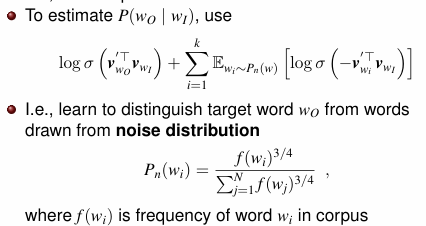


Text(0.5, 1.0, 'Hàm mất mát theo thời gian')

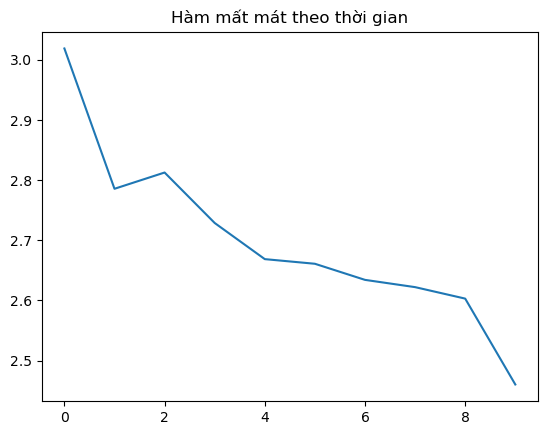

In [23]:
plt.tick_params('y')
plt.plot(loss_records)
plt.title("Hàm mất mát theo thời gian")

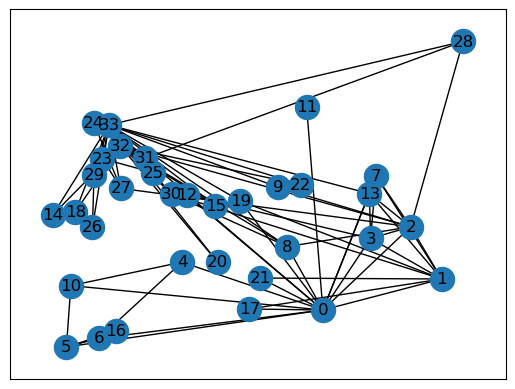

In [24]:
pos = {v: v_emb.tolist() for v, v_emb in enumerate(model.embedding_layer(tensor(list(g))))}
nx.draw_networkx(g, pos)